# 情绪指标近 250 个交易日可视化
指标：**蓝色实线** ｜ 上证指数：**红色实线**
阈值：多色虚线；涨停板占比左轴上限设为 5，交易拥挤度左轴上限设为 1.5。

```bash
pip install pandas matplotlib
```
请将 `百年情绪指标.xlsx` 与本 Notebook 放在同一目录，运行全部单元格即可生成 9 张图。

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

plt.rcParams['figure.dpi'] = 110
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置微软雅黑/黑体
plt.rcParams['axes.unicode_minus'] = False    # 解决负号显示异常


In [2]:
file_path = Path('百年情绪指标.xlsx')  # 修改为实际路径

def load_sh_index(xls):
    df = pd.read_excel(
        xls, 'ERP底稿', header=2, usecols=['日期.1', '上证指数.1']
    ).rename(columns={'日期.1':'Date', '上证指数.1':'上证指数'})
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    return df.dropna(subset=['Date']).set_index('Date')['上证指数'].astype(float)


In [3]:
INDICATOR_COLOR = '#1f77b4'  # 蓝
INDEX_COLOR = '#d62728'      # 红
THRESH_COLORS = ['#6c757d', '#17becf', '#ff7f0e', '#2ca02c', '#9467bd']

def plot_series(ax, dates, values, label):
    ax.plot(dates, values, color=INDICATOR_COLOR, lw=1.4, label=label)

def add_thresholds(ax, thresholds, mode='static'):
    if mode == 'static':
        for i, lvl in enumerate(thresholds):
            ax.axhline(
                lvl, ls='--', lw=0.9,
                color=THRESH_COLORS[i % len(THRESH_COLORS)],
                label='阈值' if i == 0 else None
            )
    else:
        for i, (name, ser) in enumerate(thresholds.items()):
            ax.plot(
                ser.index, ser, ls='--', lw=0.9,
                color=THRESH_COLORS[i % len(THRESH_COLORS)],
                label=name if i == 0 else None
            )

def finalize(ax1, ax2, title):
    ax1.set_title(title)
    ax1.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1, interval=1))
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax1.grid(True, ls='--', lw=0.3, alpha=0.6)
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=8)
    plt.tight_layout()


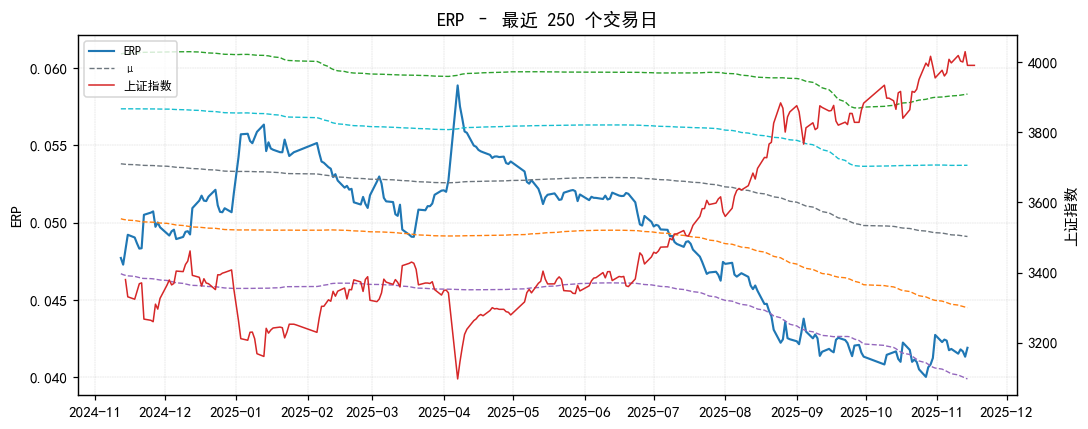

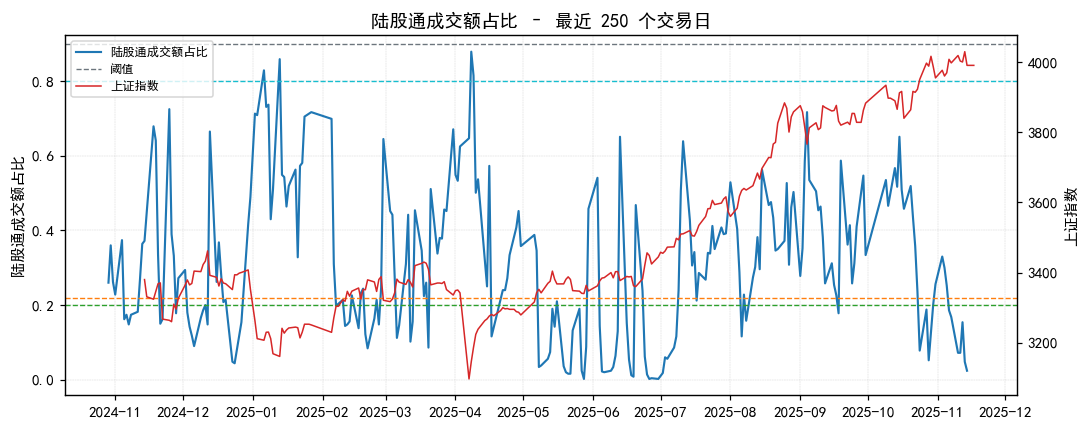

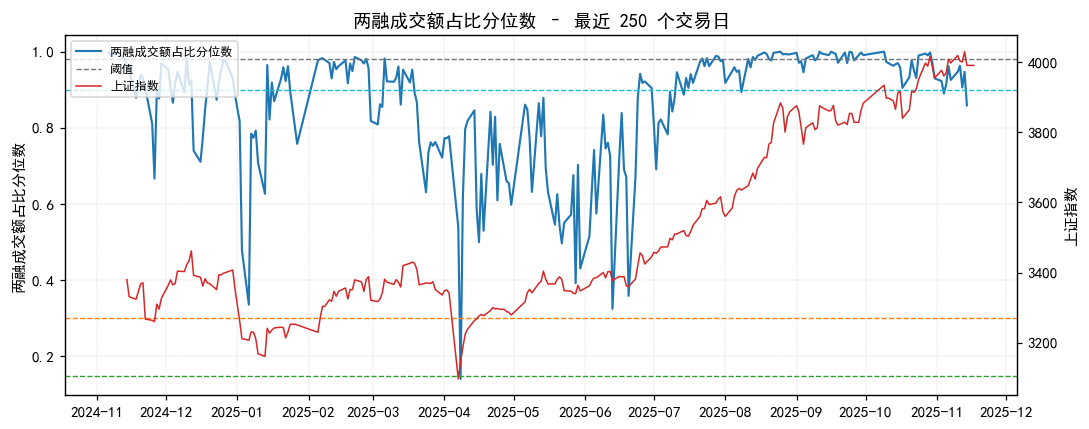

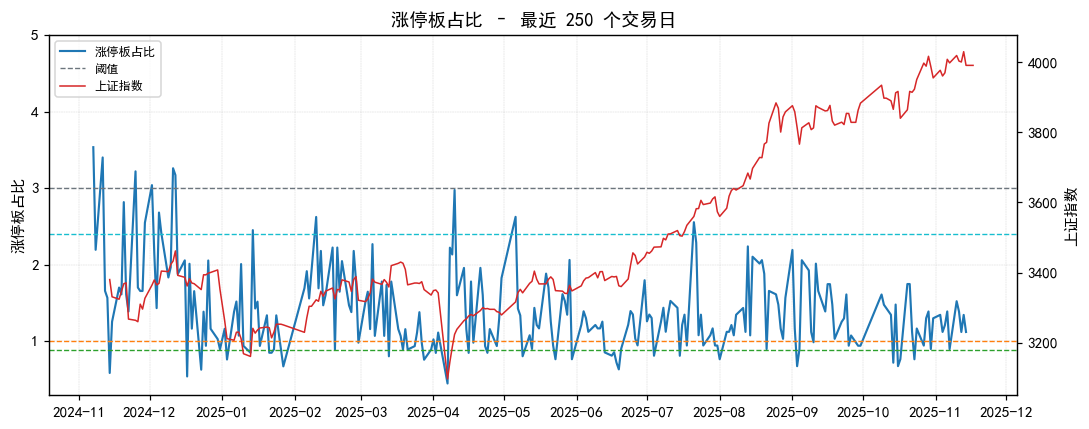

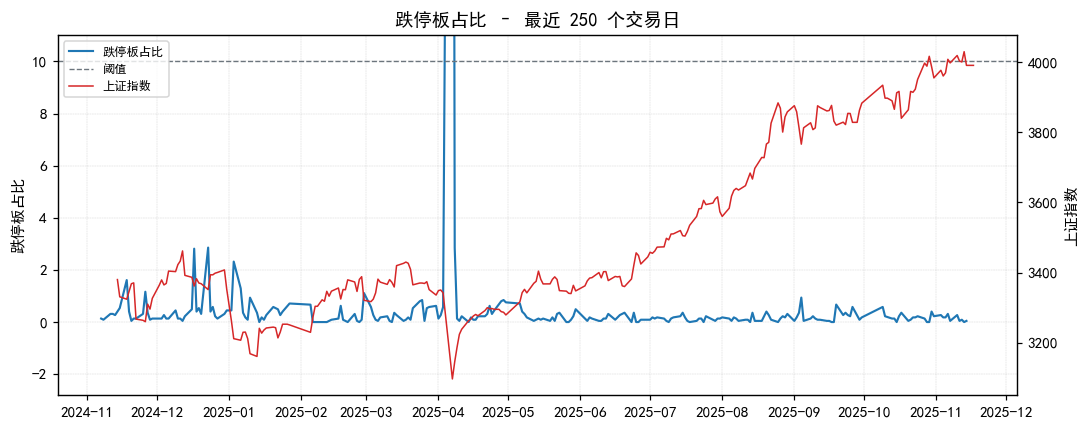

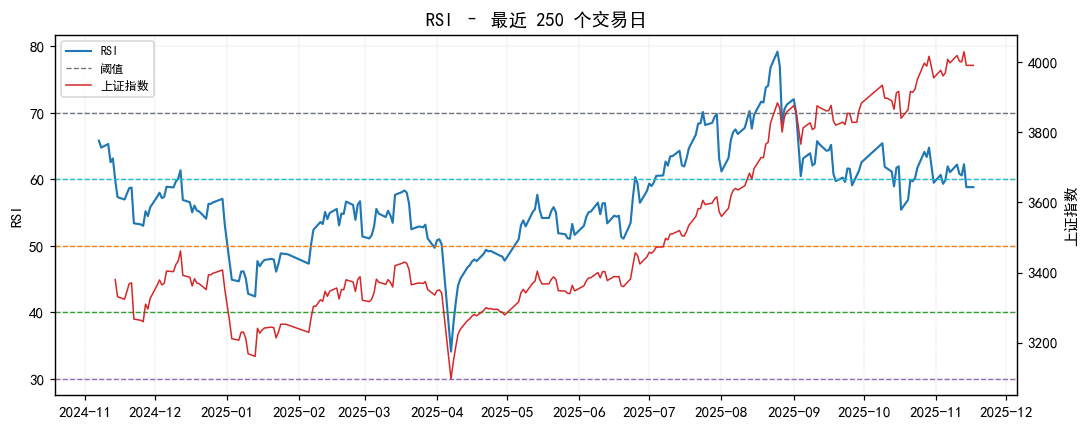

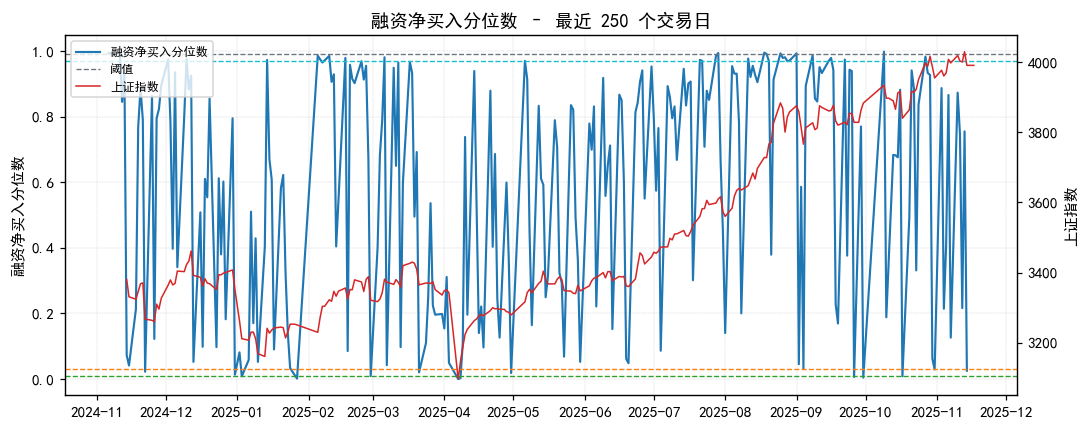

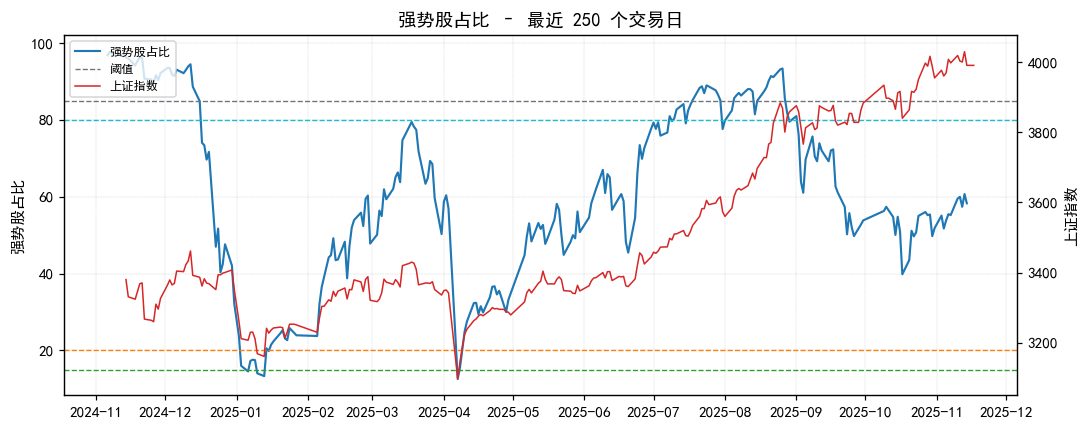

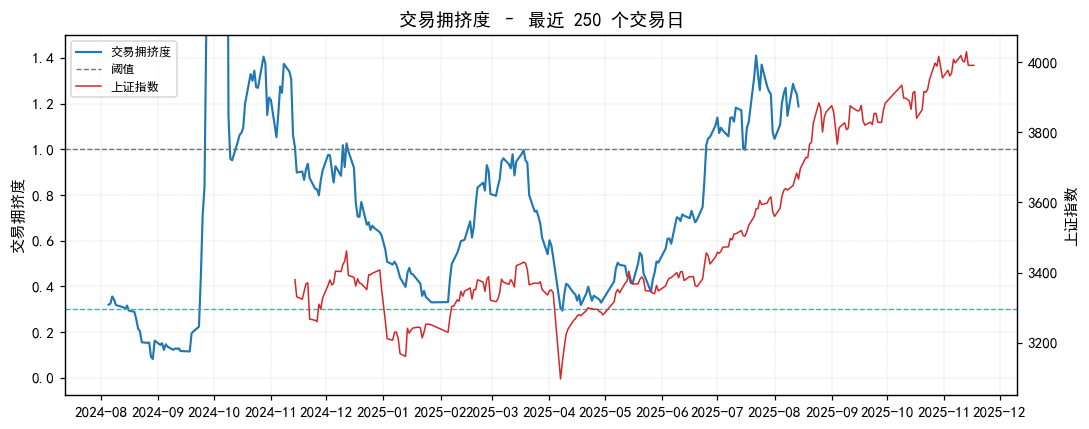

In [4]:
xls = pd.ExcelFile(file_path)
sh_idx_full = load_sh_index(xls)
sh_idx = sh_idx_full.tail(250)  # 上证指数近 250

# 1. ERP
erp = pd.read_excel(xls, 'ERP最终数据')
erp['Date'] = pd.to_datetime(erp['Unnamed: 0'])
erp = erp.set_index('Date')
erp_last = erp.tail(250)

mean = erp['ERP'].rolling(250, min_periods=250).mean()
std = erp['ERP'].rolling(250, min_periods=250).std()
dyn = {
    'μ': mean.tail(250),
    'μ+1σ': (mean + std).tail(250),
    'μ-1σ': (mean - std).tail(250),
    'μ+2σ': (mean + 2*std).tail(250),
    'μ-2σ': (mean - 2*std).tail(250)
}

fig, ax1 = plt.subplots(figsize=(10,4))
plot_series(ax1, erp_last.index, erp_last['ERP'], 'ERP')
add_thresholds(ax1, dyn, mode='dynamic')
ax2 = ax1.twinx()
ax2.plot(sh_idx.index, sh_idx, color=INDEX_COLOR, lw=1, label='上证指数')
ax1.set_ylabel('ERP'); ax2.set_ylabel('上证指数')
finalize(ax1, ax2, 'ERP – 最近 250 个交易日')

# 2‑9 其他指标
cfgs = [
    ('陆股通成交额占比最终数据',0,'指标名称','陆股通成交占比分位数',[0.9,0.8,0.22,0.2],'陆股通成交额占比'),
    ('两融成交额分位数',0,'Unnamed: 0','两融交易额占比分位数',[0.98,0.9,0.3,0.15],'两融成交额占比分位数'),
    ('涨停板占比',2,'日期','涨停的股票占指数成份股的比例_PIT',[3,2.4,1,0.88],'涨停板占比'),
    ('跌停板占比',2,'日期','跌停的股票占指数成份股的比例_PIT',[10],'跌停板占比'),
    ('RSI底稿',2,'日期','RSI相对强弱指标\n[周期数]30',[70,60,50,40,30],'RSI'),
    ('融资净买入分位数',0,'Unnamed: 0','融资净买入分位数',[0.99,0.97,0.03,0.01],'融资净买入分位数'),
    ('强势股占比',0,'日期','MA60以上个股占比',[85,80,20,15],'强势股占比'),
    ('交易拥挤度',0,'日期','交易拥挤度',[1.0,0.30],'交易拥挤度'),
]

for sheet,hdr,dcol,vcol,levels,title in cfgs:
    df = pd.read_excel(xls, sheet_name=sheet, header=hdr)             .rename(columns={dcol:'Date', vcol:'Value'})
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df = df.dropna(subset=['Date']).set_index('Date')
    df_last = df.tail(250)

    fig, ax1 = plt.subplots(figsize=(10,4))
    plot_series(ax1, df_last.index, df_last['Value'], title)
    add_thresholds(ax1, levels, mode='static')

    # 特定指标 y 轴上限
    if title == '涨停板占比':
        ax1.set_ylim(top=5)
    if title == '跌停板占比':
        ax1.set_ylim(top=11)
    if title == '交易拥挤度':
        ax1.set_ylim(top=1.5)

    ax2 = ax1.twinx()
    ax2.plot(sh_idx.index, sh_idx, color=INDEX_COLOR, lw=1, label='上证指数')
    ax1.set_ylabel(title); ax2.set_ylabel('上证指数')
    finalize(ax1, ax2, f'{title} – 最近 250 个交易日')

plt.show()
